# Thesis Notebook - Draft

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import warnings

import statsmodels.api as sm

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import norm

from semipar.estimation.estimate import semipar_fit

from hackathon_auxiliary import plot_common_support
from hackathon_auxiliary import parametric_mte
from hackathon_auxiliary import par_weights
from hackathon_auxiliary import bootstrap
from hackathon_auxiliary import par_fit

from grmpy.estimate.estimate_output import calculate_mte
from grmpy.check.auxiliary import read_data
from grmpy.read.read import read

warnings.filterwarnings('ignore')

## Common Support - Full Sample

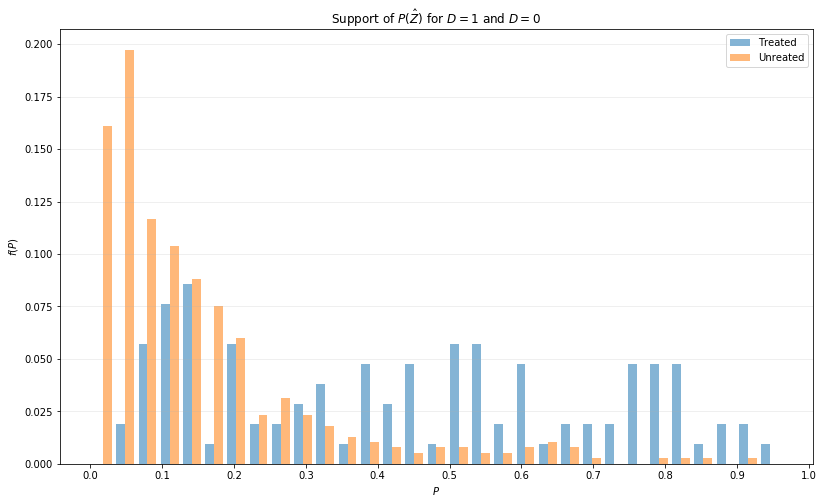

In [2]:
# full sample (males and females) without migration background, n = 490
plot_common_support("semipar/files/soep_uni03.yml", nbins=31) 

Common support ranges from 0.04 to 0.72. It goes up to 0.91 when the number of histogram bins is decreased.

The sample is composed of 490 indiviudals without migration background, including men and women born between 1950 and 1971 in West Germany. Dropping females would drastically reduce sample size, which would be problematic for the common support assumption. <br>

Identification of the MTE depends critically on the common support of the propensity score. Common support is defined as the region where the support of $P(z)$ given $D=1$ and the support of $P(z)$ given $D=0$ overlap.

It is not the simply the range from the smallest propensity observed in the treated sample to the maximum propensity observed in the untreated sample, as their marginal supports might not overlap in between. This would become evident by "holes" and "dents" in the histograms above. 

Although we observe positive frequencies for $P(z)$ up to 0.91 in the untreated subpopulation, the continuously overlapping support stops at 0.72.

Reducing the sample size even further (dropping females) produces sparse regions under the histograms. Hence, common support cannot be established. See below:

### <font color='red'> _Common Support - Males only_ </font>

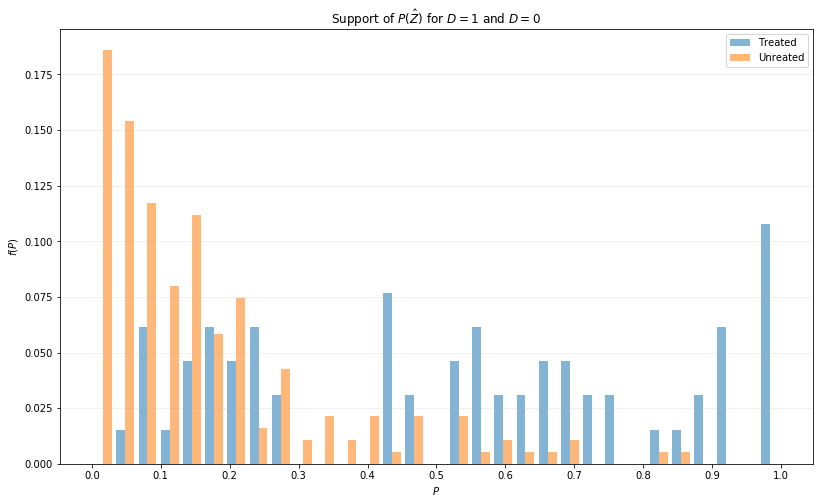

In [3]:
# male only sample, n = 253
plot_common_support("semipar/files/soep_uni02.yml", nbins=31, savefig=False) 

# Estimating _MTE_ through _Local Instrumental Variables_ (_LIV_)

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  490
Model:                         Probit   Df Residuals:                      461
Method:                           MLE   Df Model:                           28
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2634
Time:                        20:52:11   Log-Likelihood:                -187.53
converged:                       True   LL-Null:                       -254.59
                                        LLR p-value:                 8.245e-16
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2294.2779   1146.290      2.001      0.045      47.591    4540.965
sex                          -0.4182      0.152     -2.752      0.006      -0.716     

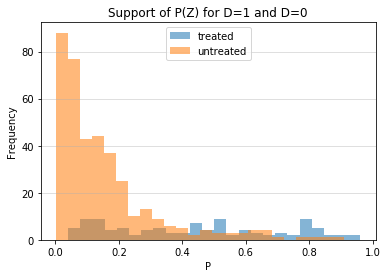

In [4]:
quantiles, mte_u, X, b1_b0 = semipar_fit("semipar/files/soep_uni03.yml")

In [5]:
# Calculate MTE component that depends on X
mte_x = np.dot(X, b1_b0).mean(axis=0)

# Put the MTE together
mte = mte_x + mte_u

# Accounting for variation in X
mte_x_ = np.dot(X, b1_b0)

mte_min = np.min(mte_x_) + mte_u
mte_max = np.max(mte_x_) + mte_u

print(np.min(mte_min / 5))
print(np.max(mte_max / 5))

-0.9575853758815726
0.8049182387628804


In [6]:
np.random.seed(123)

In [7]:
# Draw n bootstrap samples and calculate MTE estimates.
# very volatile
nbootstraps = 250
mte_boot = bootstrap("semipar/files/soep_uni03_boot.yml", nbootstraps)

In [8]:
# mte per year of university education
mte_5 = mte / 5
mte_boot_5 = mte_boot / 5

# Get standard error of MTE at each gridpoint u_D
mte_boot_std = np.std(mte_boot_5, axis=1)

# Compute 90 percent confidence intervals
con_u = mte_5 + norm.ppf(0.95) * mte_boot_std
con_d = mte_5 - norm.ppf(0.95) * mte_boot_std

### Returns per one year of university education

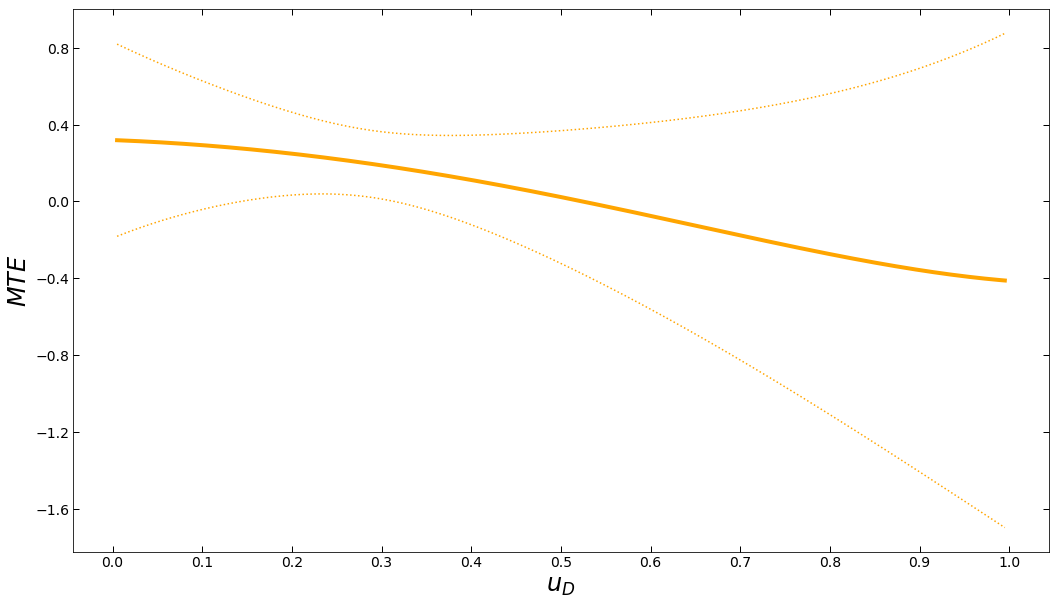

In [9]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both" ,direction='in', length=6, width=1, grid_alpha=0.25, labelsize=14)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks(np.arange(0, 1.1, step=0.1))
ax.yaxis.set_ticks(np.arange(-1.6, 1.1, step=0.4))


ax.plot(quantiles, mte/5, label="$no migrants$", color="orange", linewidth=4)
ax.plot(quantiles, con_u, color="orange", linestyle=':')
ax.plot(quantiles, con_d, color="orange", linestyle=':')

plt.show()

People with the highest returns to education (those who have low unobserved resistance $u_D$ ) are more likely to go to college. <br>
Note that the returns vary considerably with $u_D$. Low $u_D$ students have returns of up to 32% per year of university, whereas high $u_D$ people, who would loose from pursuing a post-secondary degree, have returns of approximately - 40%.

The total degree of heterogeneity is probably even higher, as the _MTE_ depicts the average gain of one year of post-secondary education _at the mean values of X_, i.e. $\bar{x} (\beta_1 - \beta_0)$. Accounting for the variation in $X$, returns can be as low as -96% and as high as 80%.

## Parametric Normal Specification

In [10]:
rslt = par_fit("semipar/files/soep_uni03_par.yml")
par_quantiles, par_mte, mte_up, mte_d = parametric_mte(rslt, "semipar/files/soep_uni03_par.yml")

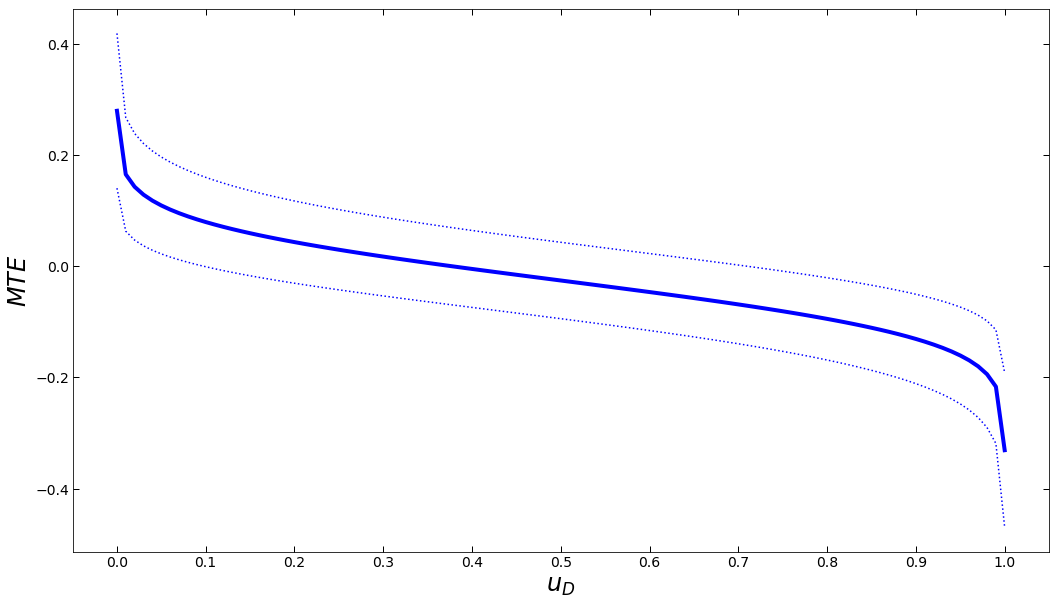

In [11]:
par_mte5 = [i / 5 for i in par_mte]

# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both" ,direction='in', length=6, width=1, grid_alpha=0.25, labelsize=14)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks(np.arange(0, 1.1, step=0.1))
ax.yaxis.set_ticks(np.arange(-0.4, 0.5, step=0.2))

ax.plot(par_quantiles, par_mte5, label="$full sample$", color="blue", linewidth=4)
ax.plot(par_quantiles, [i / 5 for i in mte_up], color="blue", linestyle=':')
ax.plot(par_quantiles, [i / 5 for i in mte_d], color="blue", linestyle=':')

plt.show()

## Weights of Conventional Treatment Parameters 

Estimation of _ATE_, _TT_, and _TUT_ requires full support of the propensity score.
Hence they are not defined in a _Local Instrumental Variable_ setup, 
where the common support of $P(z)$ is typically not the full unit interval. <br>
However, we can estimate such parameters in the normal model due to its parametric assumptions.

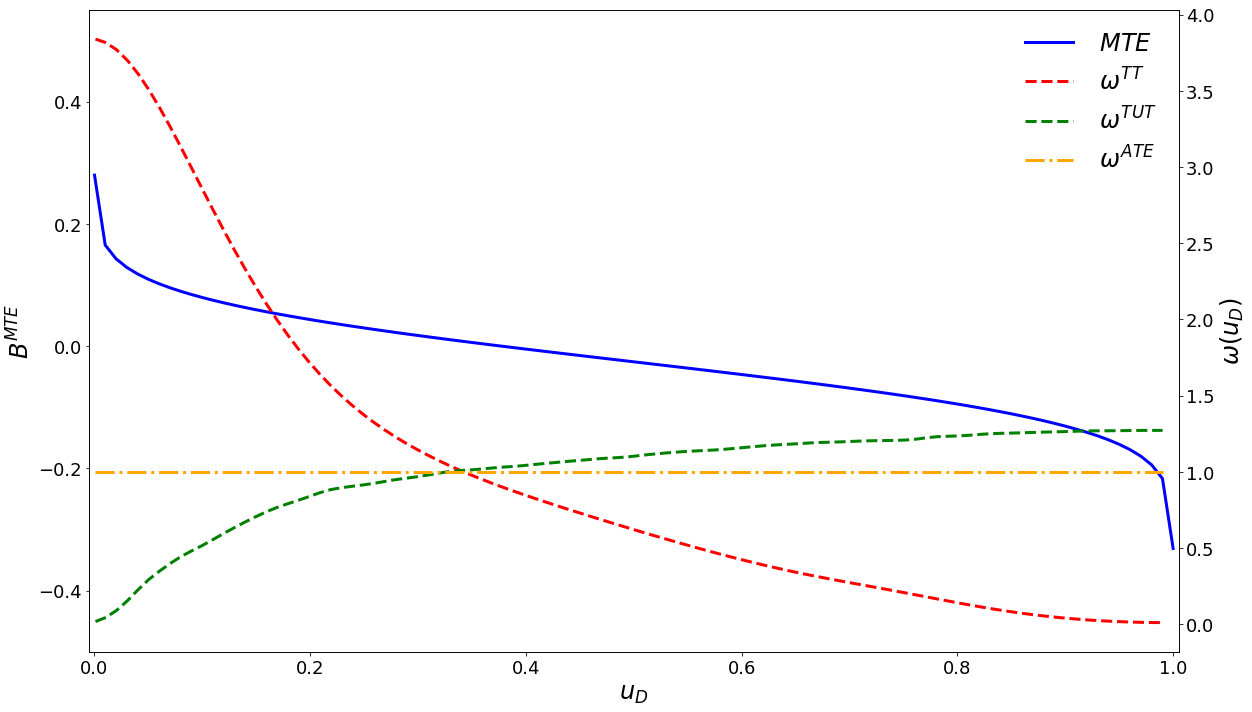

In [12]:
# Plot weights of conventional treatment parameters
tt, tut = par_weights(rslt, 
                      par_mte5, 
                      par_quantiles, 
                      "semipar/files/soep_uni03_par.yml", 
                      smooth_tt=6, smooth_tut=1, output='par_weights')